## Questions

1.	What factors play into police stops.
    a.	Given pieces of data about a particular stop, to what extent can we predict the race of the subject. 
    i.	AM vs PM 
2.	Can we predict what precincts that are more likely to pull over a particular gender/race. 
    a.	AM vs PM
3.	What is the correlation of prerace actually being accurate to actual race. 
4.	Are there times of higher citations. Morning, Afternoon, Evening, Night. 
5. Does the type of traffic stop impact whether a person is searched? H1 If suspicious vehicle stops are related to a person being searched, then the percentage of searches will be higher than the regular traffic stops for the year; H0 If suspicious vehicle stops are not related to a person being serarched, then the percentage of searches will be approximately equal for the year.



In [1]:
# importing dependencies
import numpy as np 
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import requests
import time
import json
import datetime
from pprint import pprint

# Google developer API key
#from config import google_key

# Census developer API key
#from config import census_key

## Data Load, Prep and Review

In [125]:
# reading csv file
StopOriginal = pd.read_csv('MplsStops_base.csv', parse_dates=['date'], infer_datetime_format=True)

StopOriginal['Time'] = StopOriginal.date.dt.time

# def get_sec(time_str):
#     h, m, s = time_str.split(':')
#     return int(h) * 3600 + int(m) * 60 + int(s)

# for time in StopOriginal:
#     convertedTime = get_sec(time['Time'])
#     StopOriginal.append({'convertedTime': convertedTime})

# displaying file header and five rows
StopOriginal.head()


,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


### Total Stops per Precinct

In [4]:
#stops per precinct 
StopOriginal['policePrecinct'].value_counts()

5    12825
4    12273
3     9792
2     9478
1     7552
Name: policePrecinct, dtype: int64

In [5]:
# storing csv into a pandas dataframe
initDF = pd.DataFrame(StopOriginal)
initDF.head()

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


### Count of Stops (Removed 'other' values from MCD column)

In [6]:
#stops per police precinct after removing 'other' values from MDC column
cleanDF = initDF.drop(initDF[initDF.MDC == 'other'].index)
cleanDF['policePrecinct'].value_counts()

5    11435
4    10726
3     8345
2     7944
1     5249
Name: policePrecinct, dtype: int64

In [7]:
#data just for precinct 1 
precinct_one = cleanDF.loc[cleanDF['policePrecinct'] == 1 ]
precinct_two = cleanDF.loc[cleanDF['policePrecinct'] == 2 ]
precinct_three = cleanDF.loc[cleanDF['policePrecinct'] == 3 ]
precinct_four = cleanDF.loc[cleanDF['policePrecinct'] == 4 ]
precinct_five = cleanDF.loc[cleanDF['policePrecinct'] == 5 ]

In [8]:
one = precinct_one['problem'].value_counts()
one

suspicious    3326
traffic       1923
Name: problem, dtype: int64

### Total Stops

In [9]:
# calculating total stops 
precinct_df = pd.DataFrame(cleanDF['policePrecinct'].value_counts())
stops = precinct_df['policePrecinct'].sum()
stops

43699

### Count/Percent of Stops by Race

,race,%
Black,15220,34.83%
White,11703,26.78%
Unknown,9219,21.10%
East African,2188,5.01%
Latino,1858,4.25%
Native American,1516,3.47%
Other,1348,3.08%
Asian,647,1.48%


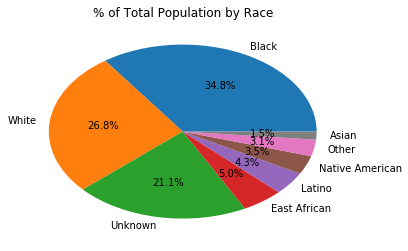

In [10]:
# Count of Stops by Race
race_count = pd.DataFrame(cleanDF['race'].value_counts())
race_count['%'] = race_count['race'] / stops * 100
race_count['%'] = race_count['%'].map("{:.2f}%".format)
display(race_count)
labels = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']
plt.pie(race_count['race'], labels=labels, autopct="%1.1f%%")
# adding title
plt.title("% of Total Population by Race")
# save the figure
plt.savefig("percent_pop_race.png")
# show the figure
plt.show()

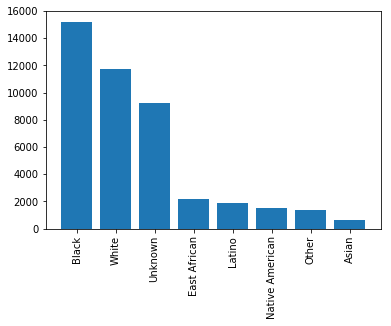

In [11]:
# the labels need to be fixed and despite about 5 attempts, I cannot find the magical code to do that
race_type = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']
race_cnts = race_count['race'].values.tolist()
plt.bar(race_type, race_cnts,  align='center')
plt.xticks(rotation='vertical')
plt.show()

## Q4: Are there instances of higher stops by morning, afternoon, evening, night?

In [12]:
# grouping by time of day
cleanDF['id_date'] = pd.to_datetime(cleanDF['date'], errors='coerce')
cleanDF.set_index('id_date', inplace=True)
# timeDF = cleanDF.groupby(['policePrecinct', pd.Grouper(key='date',freq='6h')]) ['problem'].value_counts()
# timeDF

grouper = pd.Grouper(freq='6h')
cleanDF.index = cleanDF.reset_index()['id_date'].apply(lambda x: x - pd.Timestamp(x.date()))
time_of_day = cleanDF.groupby(grouper).count()
time_of_day



,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
id_date,,,,,,,,,,,,,,,,
00:00:00,8813,8813,8813,8813,8813,3531,8813,8813,8813,8813,8799,8813,8813,8813,8813,8813
06:00:00,6681,6681,6681,6681,6681,3103,6681,6681,6681,6681,6673,6681,6681,6681,6681,6681
12:00:00,11809,11809,11809,11809,11809,5466,11809,11809,11809,11809,11793,11809,11809,11809,11809,11809
18:00:00,16396,16396,16396,16396,16396,7010,16396,16396,16396,16396,16373,16396,16396,16396,16396,16396


In [151]:
timeDF = cleanDF.groupby(grouper) ['policePrecinct'].value_counts()
timeDF = pd.DataFrame(timeDF)
#timeDF

In [149]:
timeDF4 = cleanDF.groupby([grouper, 'problem']) ['race'].value_counts()
timeDF4 = pd.DataFrame(timeDF4)
#timeDF4

In [15]:
timeDF2 = cleanDF.groupby(grouper) ['problem'].value_counts()
timeDF2 = pd.DataFrame(timeDF2)
timeDF2 = timeDF2.rename(columns={'problem':'count'})




In [150]:
timeDF3 = cleanDF.groupby(grouper)['race'].value_counts()
timeDF3 = pd.DataFrame(timeDF3)
#timeDF3




### Stops by Race per Precinct

In [17]:
# stops per precinct by race
# count of stops per race per precinct
one_race_count = pd.DataFrame(precinct_one['race'].value_counts())
one_race_count = one_race_count.rename(columns={'race':'one'})

two_race_count = pd.DataFrame(precinct_two['race'].value_counts())
two_race_count = two_race_count.rename(columns={'race':'two'})

three_race_count = pd.DataFrame(precinct_three['race'].value_counts())
three_race_count = three_race_count.rename(columns={'race':'three'})

four_race_count = pd.DataFrame(precinct_four['race'].value_counts())
four_race_count = four_race_count.rename(columns={'race':'four'})

five_race_count = pd.DataFrame(precinct_five['race'].value_counts())
five_race_count = five_race_count.rename(columns={'race':'five'})

#stops per precinct by race
stops_per_precinct_by_race = pd.concat([one_race_count,two_race_count,three_race_count,four_race_count,five_race_count], axis=1, sort=True)
stops_per_precinct_by_race = stops_per_precinct_by_race.reset_index()
stops_per_precinct_by_race = stops_per_precinct_by_race.rename(columns={'index':'race'})
stops_per_precinct_by_race = stops_per_precinct_by_race[['race','one','two','three','four','five']]
stops_per_precinct_by_race['Total'] = stops_per_precinct_by_race.sum(axis=1)

stops_per_precinct_by_race




,race,one,two,three,four,five,Total
0,Asian,65,165,53,177,187,647
1,Black,2176,2226,2059,6183,2576,15220
2,East African,286,364,463,127,948,2188
3,Latino,100,429,543,216,570,1858
4,Native American,192,119,750,108,347,1516
5,Other,165,304,273,228,378,1348
6,Unknown,897,1033,2893,2494,1902,9219
7,White,1368,3304,1311,1193,4527,11703


### Stops By Precinct Per Race Bar Charts

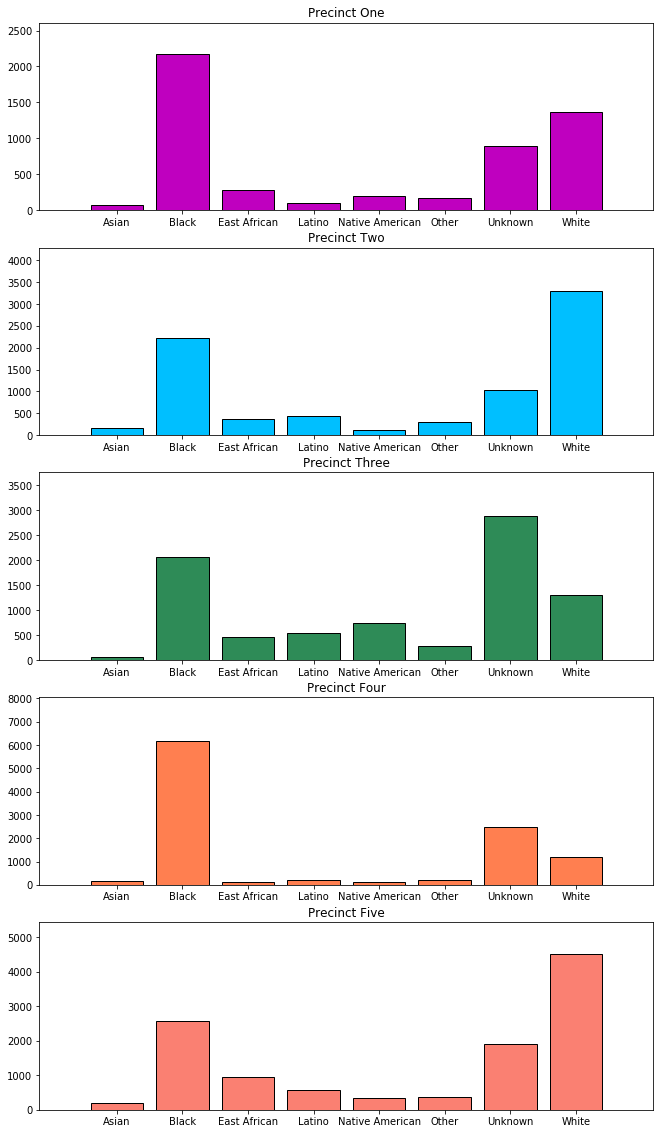

In [31]:
#splitting up df to segment by precicnt
stppbr = stops_per_precinct_by_race
stppbr

one = pd.DataFrame(stppbr.iloc[:, [0,1]])  
two = pd.DataFrame(stppbr.iloc[:, [0,2]]) #data.iloc[[0,3,6,24], [0,5,6]]
three = pd.DataFrame(stppbr.iloc[:, [0,3]])
four = pd.DataFrame(stppbr.iloc[:, [0,4]])
five = pd.DataFrame(stppbr.iloc[:, [0,5]])
six = pd.DataFrame(stppbr.iloc[:, [0,6]])

#plotting
fig1,ax = plt.subplots(5,1 , figsize=(11,20))

ax[0].bar(one.race,one.one,  color='m', label='One',edgecolor='black')
ax[1].bar(two.race,two.two,  color='deepskyblue', label='Two',edgecolor='black')
ax[2].bar(three.race,three.three,  color='seagreen', label='Three',edgecolor='black')
ax[3].bar(four.race,four.four,  color='coral', label='Four',edgecolor='black')
ax[4].bar(five.race,five.five,  color='salmon', label='Five',edgecolor='black')

ax[0].margins(x=0.1,y=0.2) 
ax[1].margins(x=0.1,y=0.3) 
ax[2].margins(x=0.1,y=0.3) 
ax[3].margins(x=0.1,y=0.3) 
ax[4].margins(x=0.1,y=0.2) 

ax[0].set_title('Precinct One')
ax[1].set_title('Precinct Two')
ax[2].set_title('Precinct Three')
ax[3].set_title('Precinct Four')
ax[4].set_title('Precinct Five')

fig1.savefig('Stops_per_precinct_by_race.png')

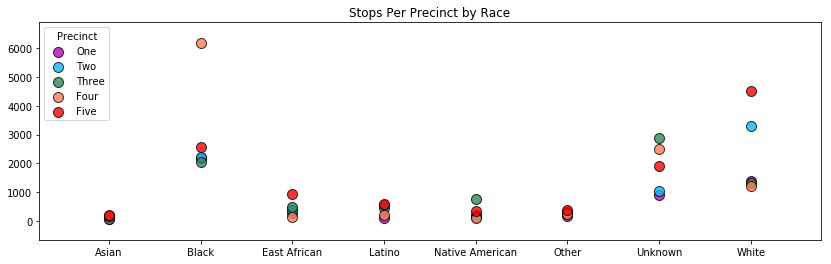

In [218]:
stppbr = stops_per_precinct_by_race
stppbr

one = pd.DataFrame(stppbr.iloc[:, [0,1]])  
two = pd.DataFrame(stppbr.iloc[:, [0,2]]) #data.iloc[[0,3,6,24], [0,5,6]]
three = pd.DataFrame(stppbr.iloc[:, [0,3]])
four = pd.DataFrame(stppbr.iloc[:, [0,4]])
five = pd.DataFrame(stppbr.iloc[:, [0,5]])
six = pd.DataFrame(stppbr.iloc[:, [0,6]])

#plotting
fig8,ax8 = plt.subplots( figsize=(14,4))

ax8.scatter(one.race,one.one, s=100, color='m', label='One',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(two.race,two.two, s=100, color='deepskyblue', label='Two',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(three.race,three.three, s=100, color='seagreen', label='Three',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(four.race,four.four, s=100, color='coral', label='Four',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.scatter(five.race,five.five, s=100, color='r', label='Five',linewidths=1 ,edgecolor='black',alpha=.8)
ax8.margins(x=0.1,y=0.2) 
ax8.legend(loc='upper left',title='Precinct')
ax8.margins(x=0.1,y=0.1) 
ax8.set_title('Stops Per Precinct by Race')

fig8.savefig('Stops_per_precinct_by_race2.png')

### Bar chart Version of above

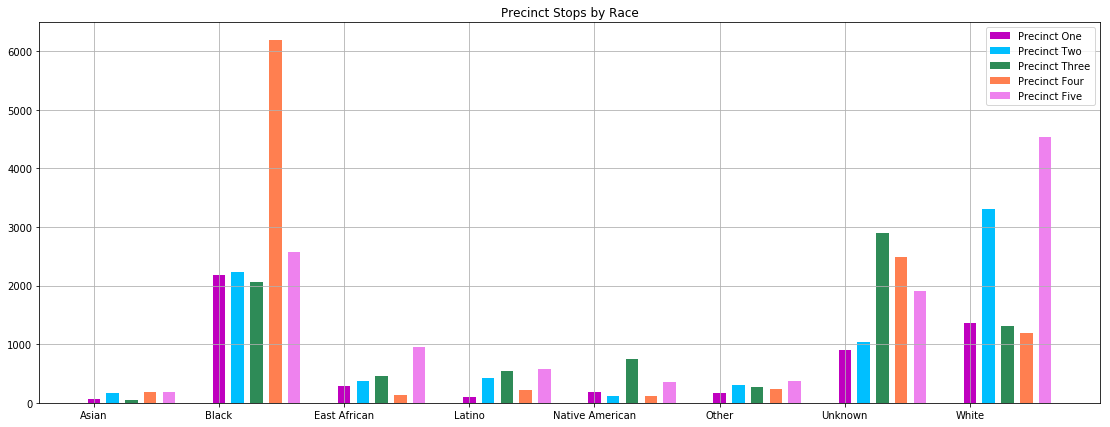

<Figure size 432x288 with 0 Axes>

In [254]:
one = stppbr['one']
two = stppbr['two']
three = stppbr['three']
four = stppbr['four']
five = stppbr['five']

fig11, ax11 = plt.subplots(figsize= (19,7) )

x = np.arange(8)
                    
ax11.bar(X + 0.00, one, color = 'm', width = 0.10, label='Precinct One')
ax11.bar(X + 0.15, two, color = 'deepskyblue', width = 0.10,label='Precinct Two')
ax11.bar(X + 0.30, three, color = 'seagreen', width = 0.10,label='Precinct Three')
ax11.bar(X + 0.45, four, color = 'coral', width = 0.10,label='Precinct Four')
ax11.bar(X + 0.60, five, color = 'violet', width = 0.10,label='Precinct Five' )
#plt.xticks('Asian','Black','East African','Latino','Native American','Other','Unknown','White')
plt.xticks([0,1,2,3,4,5,6,7], ['Asian','Black','East African','Latino','Native American','Other','Unknown','White'])
ax11.set_title('Precinct Stops by Race')
plt.legend()
plt.grid()
plt.show()

plt.savefig('precinct_stops_per_race_count_stacked.png')

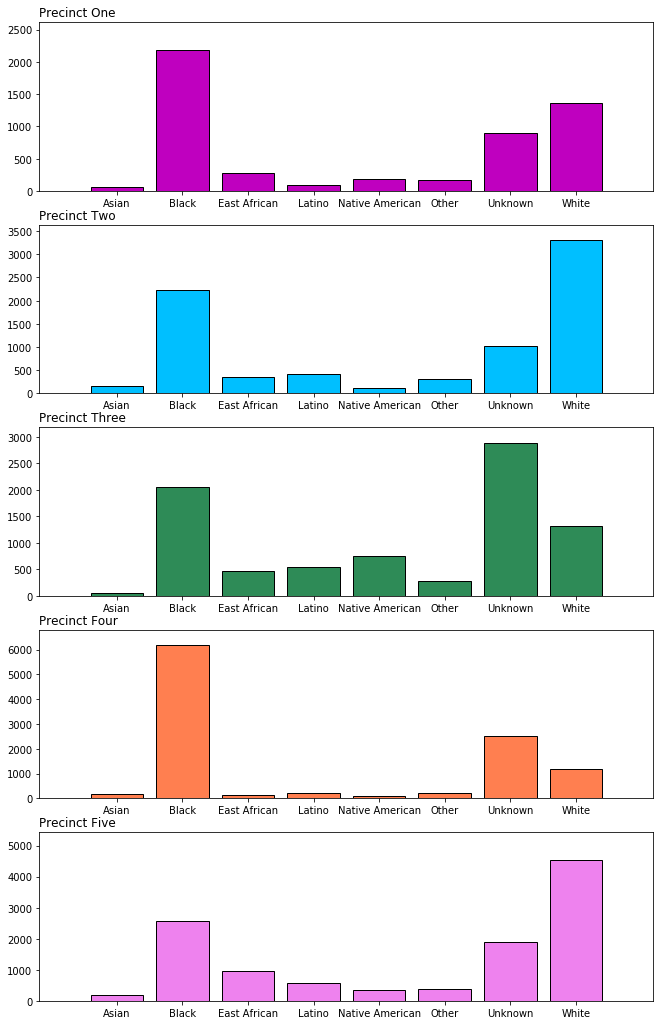

In [238]:
##splitting up df to segment by precicnt
one = pd.DataFrame(stppbr.iloc[:, [0,1]])  
two = pd.DataFrame(stppbr.iloc[:, [0,2]]) #data.iloc[[0,3,6,24], [0,5,6]]
three = pd.DataFrame(stppbr.iloc[:, [0,3]])
four = pd.DataFrame(stppbr.iloc[:, [0,4]])
five = pd.DataFrame(stppbr.iloc[:, [0,5]])
six = pd.DataFrame(stppbr.iloc[:, [0,6]])

fig2,ax = plt.subplots(5,1 , figsize=(11,18))

ax[0].bar(one.race,one.one,  color='m', label='One' ,edgecolor='black')
ax[1].bar(two.race,two.two,  color='deepskyblue', label='Two' ,edgecolor='black')
ax[2].bar(three.race,three.three,  color='seagreen', label='Three' ,edgecolor='black')
ax[3].bar(four.race,four.four,  color='coral', label='Four' ,edgecolor='black')
ax[4].bar(five.race,five.five,  color='violet', label='Five' ,edgecolor='black')

ax[0].margins(x=0.1,y=0.2) 
ax[1].margins(x=0.1,y=0.1) 
ax[2].margins(x=0.1,y=0.1) 
ax[3].margins(x=0.1,y=0.1) 
ax[4].margins(x=0.1,y=0.2) 

ax[0].set_title('Precinct One',loc='left')
ax[1].set_title('Precinct Two',loc='left')
ax[2].set_title('Precinct Three',loc='left')
ax[3].set_title('Precinct Four',loc='left')
ax[4].set_title('Precinct Five',loc='left')

fig2.savefig('Stops_per_precinct_by_race_bar.png')

### Total Stops Per Race

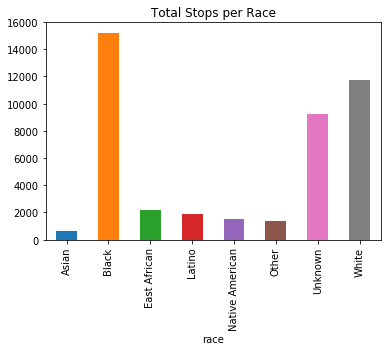

In [124]:
Total_Stops_Per_Race = stppbr.plot(kind='bar',x='race',y='Total',legend=None, title='Total Stops per Race')


### Stops by Gender per Precinct

In [22]:
# precinct stops by gender
one_sex = pd.DataFrame(precinct_one['gender'].value_counts())
two_sex = pd.DataFrame(precinct_two['gender'].value_counts())
three_sex = pd.DataFrame(precinct_three['gender'].value_counts())
four_sex = pd.DataFrame(precinct_four['gender'].value_counts())
five_sex = pd.DataFrame(precinct_five['gender'].value_counts())

precincts_sex = pd.concat([one_sex,two_sex,three_sex,four_sex,five_sex] , axis=1, sort=False)
precincts_sex.columns = ['One','Two','Three','Four','Five']
precincts_sex['Total'] = precincts_sex.sum(axis=1)
precincts_sex['%'] = precincts_sex['Total'] / precincts_sex['Total'].sum() * 100 
precincts_sex['%'] = precincts_sex['%'].map("{:.2f}%".format)
precincts_sex



,One,Two,Three,Four,Five,Total,%
Male,3664,5181,4816,6468,7002,27131,62.17%
Female,985,2109,1598,2297,3026,10015,22.95%
Unknown,593,645,1922,1943,1389,6492,14.88%


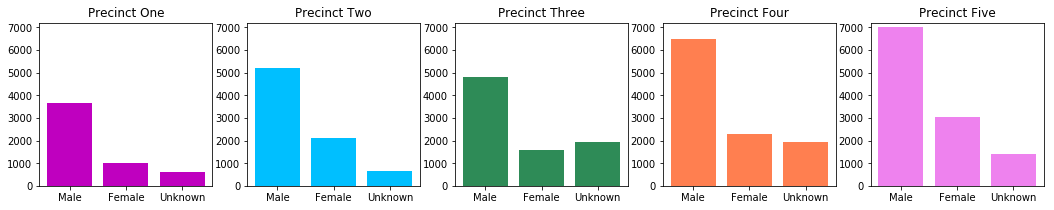

In [246]:
#chart to show num of stops per gender for each precinct

x = ('Male','Female','Unknown')
y1 = precincts_sex['One']
y2 = precincts_sex['Two']
y3 = precincts_sex['Three']
y4 = precincts_sex['Four']
y5 = precincts_sex['Five']

fig6, ax6 = plt.subplots(1,5 , figsize=(18,3))
ax6[0].bar(x,y1,  color='m')
ax6[0].set_ylim(0,7200)
ax6[0].set_title('Precinct One')

ax6[1].bar(x,y2,  color='deepskyblue')
ax6[1].set_ylim(0,7200)
ax6[1].set_title('Precinct Two')

ax6[2].bar(x,y3,  color='seagreen')
ax6[2].set_ylim(0,7200)
ax6[2].set_title('Precinct Three')

ax6[3].bar(x,y4,  color='coral')
ax6[3].set_ylim(0,7200)
ax6[3].set_title('Precinct Four')

ax6[4].bar(x,y5,  color='Violet')
ax6[4].set_ylim(0,7200)
ax6[4].set_title('Precinct Five')


fig6.savefig('Stops_per_precinct_by_gender_bar.png')

### Total Stops by Gender

In [24]:
# total stops by gender
stop_by_gender = precincts_sex[['Total','%']]
stop_by_gender

sbg = pd.DataFrame(stop_by_gender)
sbg = sbg.reset_index()
sbg = sbg.rename(columns={'index':'Gender'})
sbg

,Gender,Total,%
0,Male,27131,62.17%
1,Female,10015,22.95%
2,Unknown,6492,14.88%


### Accuracy of Pre-determined Race vs. Actual Race

In [25]:
#reading the csv
#pre_race_count = pd.DataFrame(cleanDF['preRace'].value_counts())

#summarizing data for preRace vs Race 
#e_test = e_test.loc[e_test['MDC'] == 'MDC']

#data table with only preRace classfication
pre_race = cleanDF.loc[cleanDF['preRace'] != 'Unknown'] #should we filter out other?

#see how many times preRace matched race
race_match = pre_race.loc[pre_race['preRace'] == pre_race['race']]
race_match_count = len(race_match)
print(f'{race_match_count} times preRace matched actual Race')

#see how many times preRace DID NOT match actual race
race_NA_match = pre_race.loc[pre_race['preRace'] != pre_race['race']]
race_NA_match_count = len(race_NA_match)
print(f'{race_NA_match_count} times preRace did not match Race')

race_predictions = pd.DataFrame(
                                {"Pre_Race matched Actuall Race" : [race_match_count],
                                "Pre_Race did not match Actuall Race" : [race_NA_match_count]
                                 })
race_predictions

12573 times preRace matched actual Race
2789 times preRace did not match Race


,Pre_Race matched Actuall Race,Pre_Race did not match Actuall Race
0,12573,2789


In [26]:
pre_race_count = pd.DataFrame(pre_race['preRace'].value_counts())
pre_race_count

,preRace
Black,6805
White,6004
Native American,908
Latino,528
Other,484
East African,481
Asian,152


In [27]:
#count of stops per precinct where preRace was determined 
one_count = len(pre_race.loc[pre_race['policePrecinct'] == 1])
two_count = len(pre_race.loc[pre_race['policePrecinct'] == 2])
three_count = len(pre_race.loc[pre_race['policePrecinct'] == 3])
four_count = len(pre_race.loc[pre_race['policePrecinct'] == 4])
five_count = len(pre_race.loc[pre_race['policePrecinct'] == 5])

#Breaking out by precinct whre pre race macthed actual race
race_match_one = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 1) ]
race_match_two = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 2) ]
race_match_three = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 3) ]
race_match_four = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 4) ]
race_match_five= pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 5) ]

#count of how many times each precinct matched the race correctly 
precinct_one_count = len(race_match_one)
precinct_two_count = len(race_match_two)
precinct_three_count = len(race_match_three)
precinct_four_count = len(race_match_four)
precinct_five_count = len(race_match_five)

#percent of each precinct match rate
preccint_one_percent = round(precinct_one_count / one_count * 100,2)
preccint_two_percent = round(precinct_two_count / two_count * 100,2)
preccint_three_percent = round(precinct_three_count / three_count * 100,2)
preccint_four_percent = round(precinct_four_count / four_count * 100,2)
preccint_five_percent = round(precinct_five_count / five_count * 100,2)


#print findings
print(f'Match count for precinct One {precinct_one_count}')
print(f'Precinct One was correct {preccint_one_percent}% of the time')
print("")
print(f'Match count for precinct Two {precinct_two_count}')
print(f'Precinct Two was correct {preccint_two_percent}% of the time')
print("")
print(f'Match count for precinct Three {precinct_three_count}')
print(f'Precinct Three was correct {preccint_three_percent}% of the time')
print("")
print(f'Match count for precinct Four {precinct_four_count}')
print(f'Precinct Four was correct {preccint_four_percent}% of the time')
print("")
print(f'Match count for precinct Five {precinct_five_count}')
print(f'Precinct Five was correct {preccint_five_percent}% of the time')
print("")

Match count for precinct One 2059
Precinct One was correct 87.92% of the time

Match count for precinct Two 2083
Precinct Two was correct 86.65% of the time

Match count for precinct Three 2097
Precinct Three was correct 69.41% of the time

Match count for precinct Four 2452
Precinct Four was correct 83.12% of the time

Match count for precinct Five 3882
Precinct Five was correct 83.57% of the time



In [28]:
#creating df
precint_match_df = pd.DataFrame({ 'Matches':[precinct_one_count,precinct_two_count,precinct_three_count,precinct_four_count,precinct_five_count],
                                  'Match_Rate' :[preccint_one_percent,preccint_two_percent,preccint_three_percent,preccint_four_percent,preccint_five_percent]},
                                     index=[1,2,3,4,5])
precint_match_df['Match_Rate'] = precint_match_df['Match_Rate'].map("{:.2f}%".format)

precint_match_df.index.name = 'Precinct'
precint_match_df






,Matches,Match_Rate
Precinct,,
1,2059,87.92%
2,2083,86.65%
3,2097,69.41%
4,2452,83.12%
5,3882,83.57%


### Vechile Search and Citation Issued

In [134]:
#filter the table to only include stops where the vehicle was serched and a citation was issued. 

citation_search = cleanDF.loc[(cleanDF['citationIssued'] == 'YES') & (cleanDF['vehicleSearch'] == 'YES')]
vech_search_cit = pd.DataFrame(citation_search.groupby(['race'])['race'].count())
vech_search_cit = vech_search_cit.rename(columns={'race':'Count'})
vech_search_cit['Percent'] =  vech_search_cit['Count'] / vech_search_cit['Count'].sum() * 100
vech_search_cit['Percent'] = vech_search_cit['Percent'].map("{:.2f}%".format)

#Show DF
vech_search_cit

,Count,Percent
race,,
Asian,3,0.88%
Black,223,65.40%
East African,14,4.11%
Latino,25,7.33%
Native American,4,1.17%
Other,8,2.35%
Unknown,11,3.23%
White,53,15.54%


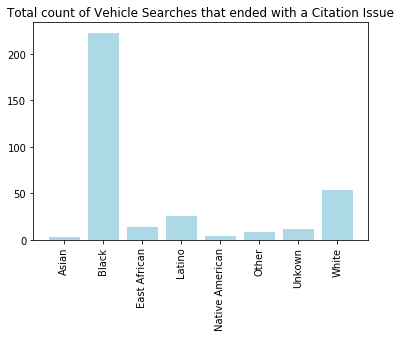

<Figure size 432x288 with 0 Axes>

In [154]:
# Bar Chart of vech_search_cit data frame

fig9, ax9 = plt.subplots()
x = ('Asian','Black','East African','Latino','Native American','Other','Unkown','White')
y = vech_search_cit['Count']

ax9.bar(x,y , color='lightblue')
plt.xticks(rotation='vertical')
plt.title('Total count of Vehicle Searches that ended with a Citation Issue')
plt.show()
plt.savefig('citations_issued_plus_search.png')

### Stops where vehicle was not searched and a citation was issued

In [153]:
#filter the table to only include stops where the vehicle was NOT serched and a citation was issued. 

citation = cleanDF.loc[(cleanDF['citationIssued'] == 'YES') & (cleanDF['vehicleSearch'] == 'NO')]
vech_cit = pd.DataFrame(citation.groupby(['race'])['race'].count())
vech_cit = vech_cit.rename(columns={'race':'Count'})
vech_cit['Percent'] =  vech_cit['Count'] / vech_cit['Count'].sum() * 100
vech_cit['Percent'] = vech_cit['Percent'].map("{:.2f}%".format)

#show DF
vech_cit

,Count,Percent
race,,
Asian,55,1.92%
Black,1282,44.67%
East African,125,4.36%
Latino,175,6.10%
Native American,82,2.86%
Other,71,2.47%
Unknown,214,7.46%
White,866,30.17%


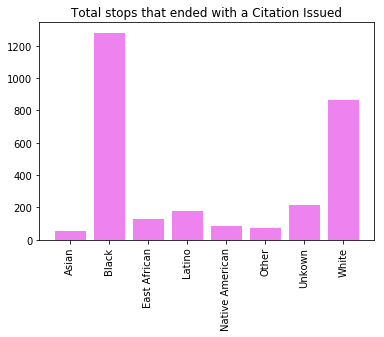

<Figure size 432x288 with 0 Axes>

In [253]:
fig10, ax10 = plt.subplots()
x = ('Asian','Black','East African','Latino','Native American','Other','Unkown','White')
y = vech_cit['Count']

ax10.bar(x,y , color='violet')
plt.xticks(rotation='vertical')
ax10.set_title('Total stops that ended with a Citation Issued')
plt.show()
plt.savefig('citations_without_vechicle_search.png')